<a href="https://colab.research.google.com/github/sbal06/Object-Detection/blob/main/SlidingWindow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.datasets import cifar10
import keras
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
import keras.optimizers as optimizers
from keras.applications import VGG16, VGG19, ResNet50, DenseNet121
from keras.optimizers import Adam, SGD
from PIL import Image
import gdown
from IPython import display


# Load image
# image_data_url = 'https://drive.google.com/uc?id=1y4nufMQqQByiz2TpXIyRDv1MxQU4caMy'
# image_data_path = './image-2.jpg'
# gdown.download(image_data_url, image_data_path, True)
!wget "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/image-2.jpg"

# image2_url = 'https://drive.google.com/uc?id=1_WpFbGEuS2r19UeP6wekbcF0kb-0nH18'
# image2_path ='./image.jpg'
# gdown.download(image2_url, image2_path, True)
!wget "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/image2.jpg"

# gif_url = 'https://drive.google.com/uc?id=1kQa0LViX33gFxdTroFVSzM11-FHypaD3'
# gif_path = './sliding.gif.png'
# gdown.download(gif_url, gif_path, True)
!wget "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/sliding.gif.png"

# Show sliding windows
def show_sliding_window():
  return display.Image(filename="sliding.gif.png")

# Construct vehicle dataset
label_car = 1
label_truck = 9

# Load data
def load_cifar10():
  (x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = cifar10.load_data()
  y_train_cifar = y_train_cifar.squeeze()
  y_test_cifar = y_test_cifar.squeeze()
  return (x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar)

# CIFAR100 classes
idx_to_class = ['background', 'car', 'truck']

# Construct vehicle dataset from CIFAR10
def construct_vehicle_dataset(data, labels, images_per_class, label_car=1, label_truck=9):
  mask_car = labels == label_car
  mask_truck = labels == label_truck

  mask_vehicles = mask_car | mask_truck
  mask_background = np.invert(mask_vehicles)

  data_car = data[mask_car]
  data_truck = data[mask_truck]
  data_background = data[mask_background][:images_per_class]

  new_data = np.vstack((data_background, data_car, data_truck))
  new_labels = np.repeat(np.array([0, 1, 2]), images_per_class, axis=0)

  return new_data, new_labels

def load_vehicle_dataset():
  (x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = load_cifar10()
  x_train, y_train = construct_vehicle_dataset(x_train_cifar, y_train_cifar, 5000)
  x_test, y_test = construct_vehicle_dataset(x_test_cifar, y_test_cifar, 1000)
  return (x_train, y_train), (x_test, y_test) # loading it as a tuple

# plotting
def plot_one_image(data, labels = [], index = None, image_shape = None, fig_size=None):
  '''
  if data is a single image, display that image

  if data is a 4d stack of images, display that image
  '''
  ### cv2.imshow('image', data)
  num_dims   = len(data.shape)
  num_labels = len(labels)
  if image_shape is not None:
    target_shape = image_shape
  else:
    target_shape = (32, 32, 3)
  # reshape data if necessary
  if num_dims == 1:
    data = data.reshape(target_shape)
  if num_dims == 2:
    data = data.reshape(np.vstack[-1, image_shape])
  num_dims   = len(data.shape)

  # check if single or multiple images
  if num_dims == 3:
    if num_labels > 1:
      print('Multiple labels does not make sense for single image.')
      return

    label = labels
    if num_labels == 0:
      label = ''
    image = data

  if num_dims == 4:
    image = data[index, :]
    label = labels[index]

  # plot image of interest
  print('Label: %s'%label)
  if fig_size is not None:
    plt.figure(figsize=fig_size)
  plt.axis('off')
  plt.imshow(image)
  plt.show()

def model_to_string(model):
  import re
  stringlist = []
  model.summary(print_fn=lambda x: stringlist.append(x))
  sms = "\n".join(stringlist)
  sms = re.sub('_\d\d\d','', sms)
  sms = re.sub('_\d\d','', sms)
  sms = re.sub('_\d','', sms)
  return sms

def normalize(data):
  # CIFAR100 mean (0.4914, 0.4822, 0.4465) std (0.2023, 0.1994, 0.2010)
  return (data/255-np.array((0.4914, 0.4822, 0.4465))) / np.array((0.2023, 0.1994, 0.2010))

def label_to_onehot(labels):
  final_labels = np.zeros((len(labels), 3))
  for i in range(len(labels)):
    label = labels[i]
    if label == 0:
      final_labels[i,:] = np.array([1, 0, 0])
    if label == 1:
      final_labels[i,:] = np.array([0, 1, 0])
    if label == 2:
      final_labels[i,:] = np.array([0, 0, 1])
  return final_labels

def plot_acc(history, ax = None, xlabel = 'Epoch #'):
  # i'm sorry for this function's code. i am so sorry.
  history = history.history
  history.update({'epoch':list(range(len(history['val_accuracy'])))})
  history = pd.DataFrame.from_dict(history)

  best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

  if not ax:
    f, ax = plt.subplots(1,1)
  sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
  sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
  ax.axhline(0.333, linestyle = '--',color='red', label = 'Chance')
  ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
  ax.legend(loc = 1)
  ax.set_ylim([0.01, 1])

  ax.set_xlabel(xlabel)
  ax.set_ylabel('Accuracy (Fraction)')

  plt.show()



def TransferClassifier_func(name, nn_params, trainable = True):
  expert_dict = {'VGG16': VGG16,
                  'VGG19': VGG19,
                  'ResNet50':ResNet50,
                  'DenseNet121':DenseNet121}

  expert_conv = expert_dict[name](weights = 'imagenet',
                                            include_top = False,
                                            input_shape = nn_params['input_shape'])
  for layer in expert_conv.layers:
    layer.trainable = trainable

  expert_model = Sequential()
  expert_model.add(expert_conv)
  expert_model.add(GlobalAveragePooling2D())

  expert_model.add(Dense(128, activation = 'relu'))
  expert_model.add(Dropout(0.3))

  expert_model.add(Dense(64, activation = 'relu'))

  expert_model.add(Dense(nn_params['output_neurons'], activation = nn_params['output_activation']))

  expert_model.compile(loss = nn_params['loss'],
                optimizer = optimizers.SGD(learning_rate=nn_params['learning_rate'], momentum=nn_params['momentum']),
                metrics=['accuracy'])

  return expert_model

# neural net parameters
image_shape          = (32, 32, 3)
nn_params = {}
nn_params['input_shape']       = image_shape
nn_params['output_neurons']    = 3
nn_params['loss']              = 'categorical_crossentropy'
nn_params['output_activation'] = 'softmax'
nn_params['learning_rate'] = 1e-3
nn_params['momentum'] = 0.9

TransferClassifier  = lambda name: TransferClassifier_func(name = name, nn_params = nn_params);

--2023-07-16 03:19:13--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/image-2.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 64.233.170.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5170 (5.0K) [image/jpeg]
Saving to: ‘image-2.jpg’

image-2.jpg         100%[===================>]   5.05K  --.-KB/s    in 0s      

2023-07-16 03:19:13 (48.3 MB/s) - ‘image-2.jpg’ saved [5170/5170]

--2023-07-16 03:19:13--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/image2.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 64.233.170.128, ...
Connect

## **Open and print the image**

(100, 160, 3)
(100, 160, 3)


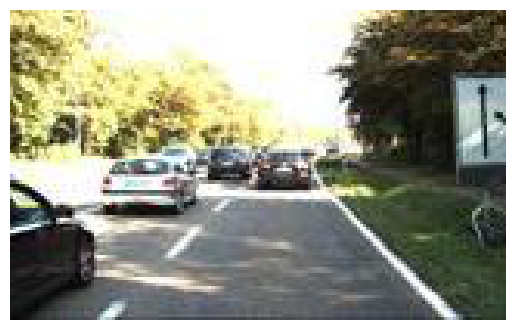

In [ ]:
image = np.asarray(Image.open('./image-2.jpg')) # using the Pillow library for images
print(image.shape)
# plot_one_image(image)
plt.axis('off')
plt.imshow(image)

# make a copy of the image so we can use the sliding window technique on it and not rewrite the old image.
image2 = image.copy()
print(image2.shape)


### **Taking a crop of an image**

Label: 


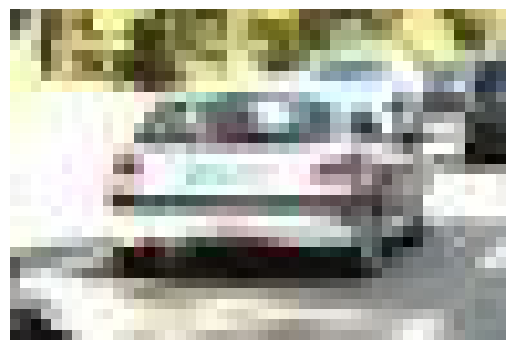

In [ ]:
# implement the sliding window classifier here:
x = 20
y = 40
window_h = 32
window_w = 48

# starting as position y, window size height is window_h
# starting as position x, window size width is window_x
plot_one_image(image2[y:y+window_h, x:x+window_w])


### **Implementing the Sliding Window Algorithm**

In the sliding window algorithm, a window of suitable size is chosen to perform a search over a target image. The code block below iterates over the x and y components of the image, and extracts partial windows.

In [ ]:

# iterate through the entire image2
strides = 16
windows = []
window_h = 32
window_w = 32


# allow partial windows on the edges to be extracted
for y in range(0, image2.shape[0], strides):
  for x in range(0, image2.shape[1], strides):
    window = image2[y:y+window_h, x:x+window_w]
    if window.shape[0] == window_h and window.shape[1] == window_w:
      windows.append(window)



### **CNN model on Cifar10 Car and Truck images**

In [ ]:
# We need a CNN to train on cars and truck images, so that we can detect them in our sliding window:

windows = np.stack(windows)
print(type(windows))


(X_train, y_train), (X_test, y_test) = load_vehicle_dataset()

y_train_one_hot = label_to_onehot(y_train)
y_test_one_hot = label_to_onehot(y_test)
cnn_model = Sequential()
cnn_model.add(Conv2D(64, (3,3), input_shape = (32, 32, 3), activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = (2,2), strides = 1))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv2D(128, (3,3), activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = (2,2), strides = 1))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv2D(256, (3,3), activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = (2,2), strides = 1))
cnn_model.add(Dropout(0.2))
cnn_model.add(Flatten())

cnn_model.add(Dense(units = 512, activation = 'relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dense(units = 3, activation = 'softmax'))
optimizer = Adam(learning_rate = 0.1, beta_1 = 0.9, beta_2 = 0.999)
cnn_model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'] )

batch_size = 128
epochs = 12
cnn_history = cnn_model.fit(X_train, y_train_one_hot, batch_size = batch_size, epochs = epochs, validation_data = (X_test, y_test_one_hot), shuffle = True)

_, test_accuracy = cnn_model.evaluate(X_train, y_train_one_hot, verbose = 1)

print(test_accuracy)

<class 'numpy.ndarray'>
170498071/170498071 [==============================] - 13s 0us/step
Epoch 1/12
118/118 [==============================] - 21s 92ms/step - loss: 1.6139 - accuracy: 0.4643 - val_loss: 8036.4219 - val_accuracy: 0.4867
Epoch 2/12
118/118 [==============================] - 9s 76ms/step - loss: 0.9386 - accuracy: 0.5765 - val_loss: 0.9157 - val_accuracy: 0.5817
Epoch 3/12
118/118 [==============================] - 9s 75ms/step - loss: 0.8073 - accuracy: 0.6523 - val_loss: 15.2384 - val_accuracy: 0.6463
Epoch 4/12
118/118 [==============================] - 9s 76ms/step - loss: 0.6905 - accuracy: 0.7135 - val_loss: 2.4098 - val_accuracy: 0.6920
Epoch 5/12
118/118 [==============================] - 9s 79ms/step - loss: 0.6559 - accuracy: 0.7291 - val_loss: 0.6854 - val_accuracy: 0.7057
Epoch 6/12
118/118 [==============================] - 9s 80ms/step - loss: 0.6466 - accuracy: 0.7335 - val_loss: 0.9296 - val_accuracy: 0.6493
Epoch 7/12
118/118 [=========================

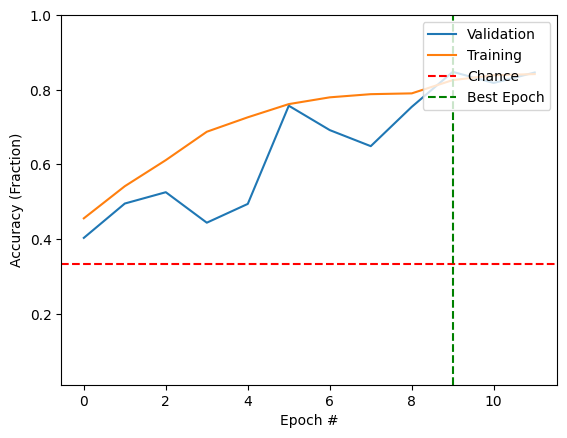

In [ ]:
plot_acc(cnn_history)

### **Predicting the accuracy of the CNN model on the windows array (stores the images).**

2/2 [==============================] - 0s 163ms/step
Label: ['Background']


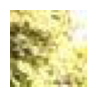

Label: ['Background']


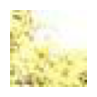

Label: ['Background']


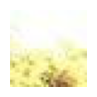

Label: ['Background']


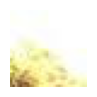

Label: ['Background']


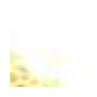

Label: ['Background']


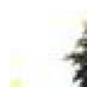

Label: ['Background']


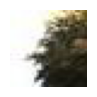

Label: ['Background']


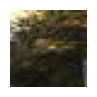

Label: ['Background']


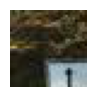

Label: ['Background']


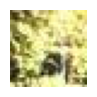

Label: ['Background']


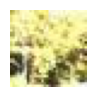

Label: ['Background']


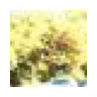

Label: ['Background']


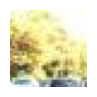

Label: ['Background']


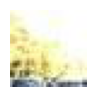

Label: ['Background']


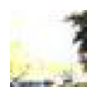

Label: ['Background']


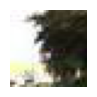

Label: ['Background']


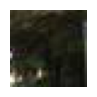

Label: ['Background']


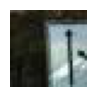

Label: ['Background']


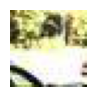

Label: ['Background']


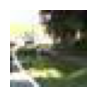

Label: ['Background']


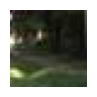

Label: ['Background']


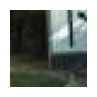

Label: ['Background']


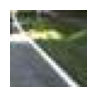

Label: ['Background']


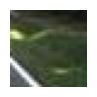

Label: ['Background']


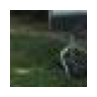

Label: ['Background']


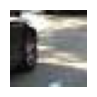

Label: ['Background']


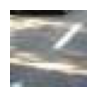

Label: ['Background']


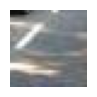

Label: ['Background']


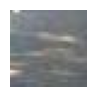

Label: ['Background']


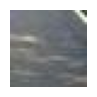

Label: ['Background']


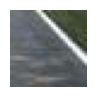

Label: ['Background']


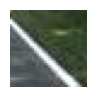

Label: ['Background']


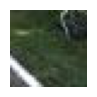

73.33%


In [ ]:
# the labels were found out ourselved by going through the windows array.

labels = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,1,1,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0])

def sliding_windows_predict(model, windows, labels = labels):
  windows_norm = normalize(windows)

  y_predict = cnn_model.predict(windows_norm) # hold the probability of each class possible

  y_predict_index = np.argmax(y_predict, axis = -1)
  classes = ['Background', 'Car', 'Truck']

  element = 0
  total_match = 0
  length = len(labels)

  while (element < length):
    if (y_predict_index[element] == labels[element]):
      total_match += 1
      plot_one_image(windows[element], labels =['.'.join([classes[labels[element]]])], fig_size = (1,1))
    element += 1
  return (total_match / length)

acc = sliding_windows_predict(cnn_model, windows)
acc = round(acc, 4)

print(str(acc*100) + "%")


# Predicted all car images wrong!


# **`Transfer Learning`**

Transfer Learning is the reuse of a pretrained model on a new problem. For our transfer learning models, we are going to use models that were built upon the famous ImageNet classification problem, where there were more than 20000 categories avaliable.


One of the expert models that we are going to use is the VGG-16 model, which achieved a 92.7% accuracy on ImageNet.

![](https://cdn-images-1.medium.com/max/1600/0*V1muWIDnPVwZUuEv.png)

The standard structure of the VGG-16 model is shown above, but we are going to implement a modified version of the VGG model since we are dealing with fewer images in the dataset.

In [ ]:
# Modified Version of the VGG-16 model:

vgg_pre_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (32, 32, 3))
vgg_model = Sequential()
vgg_model.add(vgg_pre_model)
vgg_model.add(GlobalAveragePooling2D())
vgg_model.add(Dense(1024, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(512, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(3, activation = 'softmax'))

optimizer = SGD(learning_rate = 1e-4, momentum = 0.95)
vgg_model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

X_train_norm = normalize(X_train)
X_test_norm  = normalize(X_test)

batch_size = 128
epochs = 12

vgg_history = vgg_model.fit(X_train_norm, y_train_one_hot, batch_size = batch_size, epochs = epochs, validation_data = (X_test_norm, y_test_one_hot), shuffle = True)

_, test_acc = vgg_model.evaluate(X_test_norm, y_test_one_hot, verbose = 1)
print(test_acc)

#92.5% accuracy

Epoch 1/12
118/118 [==============================] - 8s 60ms/step - loss: 0.8922 - accuracy: 0.5667 - val_loss: 0.5209 - val_accuracy: 0.7833
Epoch 2/12
118/118 [==============================] - 6s 55ms/step - loss: 0.4541 - accuracy: 0.8245 - val_loss: 0.3215 - val_accuracy: 0.8787
Epoch 3/12
118/118 [==============================] - 7s 58ms/step - loss: 0.3185 - accuracy: 0.8817 - val_loss: 0.2621 - val_accuracy: 0.9000
Epoch 4/12
118/118 [==============================] - 6s 55ms/step - loss: 0.2674 - accuracy: 0.9015 - val_loss: 0.2379 - val_accuracy: 0.9113
Epoch 5/12
118/118 [==============================] - 7s 56ms/step - loss: 0.2336 - accuracy: 0.9172 - val_loss: 0.2621 - val_accuracy: 0.9040
Epoch 6/12
118/118 [==============================] - 7s 56ms/step - loss: 0.2073 - accuracy: 0.9247 - val_loss: 0.2194 - val_accuracy: 0.9197
Epoch 7/12
118/118 [==============================] - 7s 59ms/step - loss: 0.1846 - accuracy: 0.9326 - val_loss: 0.2176 - val_accuracy: 0.9217

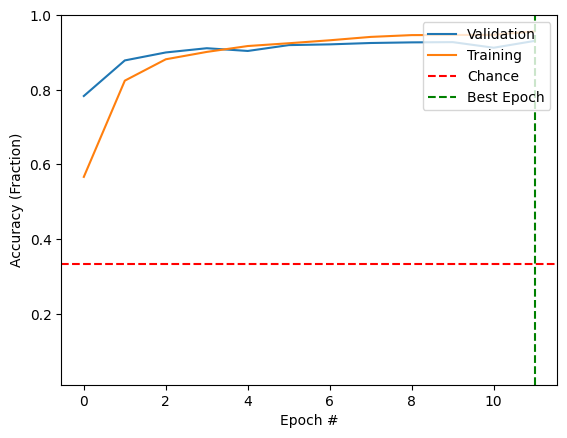

In [ ]:
plot_acc(vgg_history)

2/2 [==============================] - 0s 11ms/step
Label: ['Background']


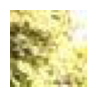

Label: ['Background']


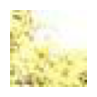

Label: ['Background']


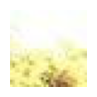

Label: ['Background']


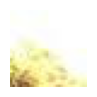

Label: ['Background']


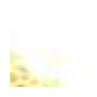

Label: ['Background']


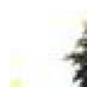

Label: ['Background']


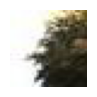

Label: ['Background']


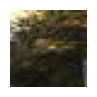

Label: ['Background']


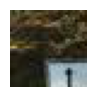

Label: ['Background']


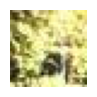

Label: ['Background']


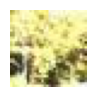

Label: ['Background']


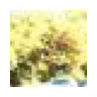

Label: ['Background']


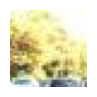

Label: ['Background']


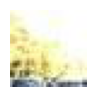

Label: ['Background']


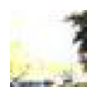

Label: ['Background']


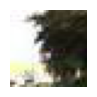

Label: ['Background']


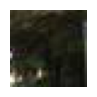

Label: ['Background']


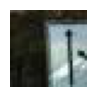

Label: ['Background']


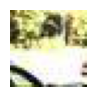

Label: ['Background']


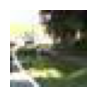

Label: ['Background']


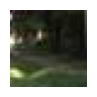

Label: ['Background']


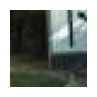

Label: ['Background']


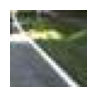

Label: ['Background']


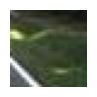

Label: ['Background']


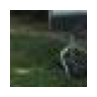

Label: ['Background']


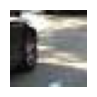

Label: ['Background']


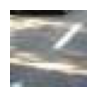

Label: ['Background']


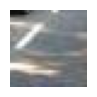

Label: ['Background']


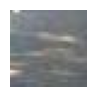

Label: ['Background']


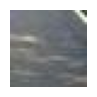

Label: ['Background']


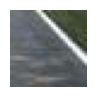

Label: ['Background']


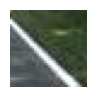

Label: ['Background']


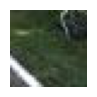

73.33%


In [ ]:
vgg16_acc = sliding_windows_predict(vgg_model, windows, labels)
vgg16_acc = round(vgg16_acc, 4)

print(str(acc*100) + "%")
